Mercari Data Exploration

Mercari is an online shopping website where sellers are able to freely set their own prices on products. Unlike for example Amazon, sellers on Mercari are all individuals rather than companies, who already know what prices to place on their products. Therefore, determining prices is more tricky for these individual sellers on Mercari. Not only do they need to take into account the branding and the quality of their item, but also its current condition. Our goal is to provide Mercari with more insight as to how to automatically suggest appropriate prices to their sellers.

In [1]:
#imports

import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [14]:
path = "/Users/jasonzhou/Documents/GuidedCapstone2"
os.chdir(path)

mercari_data = pd.read_csv("MercariDataCleaned.csv")
mercari_data = mercari_data.drop(columns=['Unnamed: 0'])

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [18]:
# Lets get a breakdown of the values, along with some descriptive statistics
print(mercari_data['Condition'].value_counts())

mercari_data['Condition'].describe()

1    452988
3    305813
2    265578
4     22484
5      1712
Name: Condition, dtype: int64


count   1048575.00000
mean          1.90743
std           0.90308
min           1.00000
25%           1.00000
50%           2.00000
75%           3.00000
max           5.00000
Name: Condition, dtype: float64

The rating system on which Condition is based on may present an inconvenience. "1" represents top condition whereas "5" represents poor condition. However, numerically speaking this scale would imply the opposite. I think it would make the data analysis more straightforward if we were to swap the scale, and have "5" represent best condition, and the opposite for "1".

In [21]:
# Swapping the values in 'Condition'

# First we swap 1's with 5's
mercari_data['Condition'] = mercari_data['Condition'].replace(1, 0).replace(5, 1).replace(0, 5)

# Now 2's with 4's
mercari_data['Condition'] = mercari_data['Condition'].replace(2, 0).replace(4, 2).replace(0, 4)

# Verify that swapping was done successfully
print(mercari_data['Condition'].value_counts())

5    452988
3    305813
4    265578
2     22484
1      1712
Name: Condition, dtype: int64


In [19]:
print(mercari_data['Shipping'].value_counts())

mercari_data['Shipping'].describe()

0    579433
1    469142
Name: Shipping, dtype: int64


count   1048575.00000
mean          0.44741
std           0.49723
min           0.00000
25%           0.00000
50%           0.00000
75%           1.00000
max           1.00000
Name: Shipping, dtype: float64

Now, ought we do the same for "Shipping", or is it acceptable the way it is? Just as a recap, the value of '0' means that shipping fees will not be paid for by the seller and the buyer will need to pay it. '1' means that the seller will cover shipping fees. I don't think it makes more sense either way, as 'Shipping' isn't really a quantifiable metric, the '0' and '1' are purely categorical. It doesn't mean anything to say that numerically, a listing has a greater "Shipping" value than another.

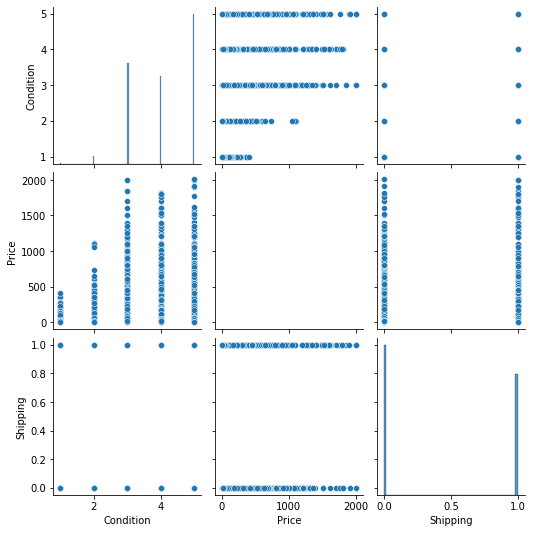

In [22]:
# Lets try to investigate and look for any correlations

sns.pairplot(mercari_data)

We can see that price and condition are intuitively positively correlated with each other. 

<AxesSubplot:>

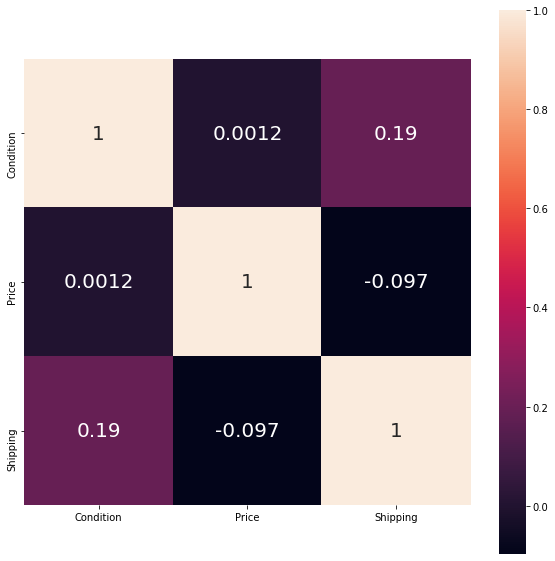

In [23]:
# Lets take a look at a heatmap too while we're at it

plt.figure(figsize=(10, 10))
sns.heatmap(mercari_data.corr(), 
            annot=True, 
            annot_kws={'size':20}, 
            square=True)

Judging by the colors of the heatmap, condition and shipping appear to have very little correlation with each other,
while the two potential correlations we discussed earlier may be worth entertaining and investigating further. Lets start with our primary interest, Price vs. Condition

<AxesSubplot:xlabel='Condition', ylabel='Price'>

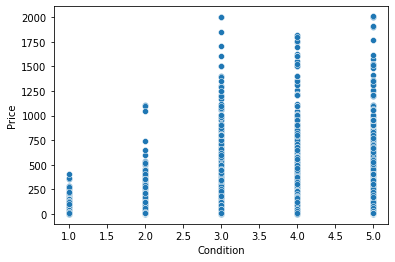

In [24]:
sns.scatterplot(data=mercari_data, x='Condition', y='Price')

<AxesSubplot:xlabel='Condition', ylabel='Price'>

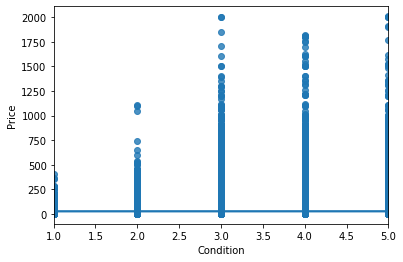

In [25]:
sns.regplot(data=mercari_data, x='Condition', y='Price')

In [26]:
mercari_data.groupby(['Condition'])['Price'].mean()

Condition
1   31.01752
2   24.33539
3   26.52099
4   27.57119
5   26.49480
Name: Price, dtype: float64

It's difficult to visualize the line of best fit because the mean of prices grouped by condition is far smaller 
compared to the range of possible values that Price can have. We will simply obtain the slope of the best fit line
using non-visual methods.

In [28]:
m, b = np.polyfit(mercari_data['Condition'], mercari_data['Price'], 1)
print("Slope: " + str(m))

Slope: 0.04962668308767962


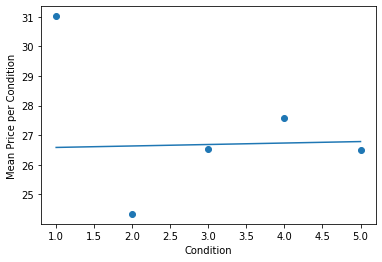

In [29]:
# Graphing Condition vs. Mean of price grouped by Condition, with best fit line included

plt.xlabel("Condition")
plt.ylabel("Mean Price per Condition")
plt.scatter(range(1, 6), mercari_data.groupby(['Condition'])['Price'].mean())
plt.plot(range(1, 6), range(1, 6) * m + b)

This at least confirms our predictions that Price should correlate positively with the value of Condition. Now lets investigate the effect of Shipping on Price. Just as a reminder, a value of 0 indicates that the seller isn't paying for shipping and needs to come from the buyer. A value of 1 indicates that the shipping will be paid for by the seller.

In [77]:
# First lets see the mean price grouped by Shipping

mercari_data.groupby(['Shipping'])['Price'].mean()

Shipping
0    30.107849
1    22.571784
Name: Price, dtype: float64

Interesting result, as it appears that sellers tend to charge higher prices when they are also not paying for shipping
as well. Lets see the distribution of listings per each shipping status:

In [79]:
mercari_data.groupby(['Shipping']).count()['Price']

Shipping
0    579433
1    469142
Name: Price, dtype: int64

These two groups are roughly equal, so this eliminates the possibility that either group is overrepresented compared
to the other.

<AxesSubplot:xlabel='Shipping', ylabel='Price'>

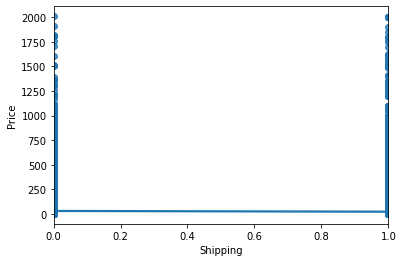

In [74]:
sns.regplot(data=mercari_data, x='Shipping', y='Price')

In [76]:
m, b = np.polyfit(mercari_data['Shipping'], mercari_data['Price'], 1)
print("Slope: " + str(m))

Slope: -7.536064298785073


The slope of the best fit line is also in line with the results thus far. Listings that require the buyer to pay for
shipping also charge higher prices overall. However this is merely correlation. Perhaps pricier listings are higher in
demand, and the seller might be able to push the shipping fees onto the buyer since they would be willing to pay it
anyways. 

Let us now take a look at the non-numeric data, starting with Brand.

In [76]:
# Get number of unique values of 'Brand'

print(mercari_data['Brand'].nunique())

# Lets then identify the Brands that are most present in the data

print(mercari_data['Brand'].value_counts())

mercari_data['Brand'] = mercari_data['Brand'].fillna("No Brand")

4384
No Brand             447335
Nike                  38161
PINK                  38123
Victoria's Secret     34159
LuLaRoe               21900
                      ...  
frogg toggs               1
Mongoose                  1
GBX                       1
Zanerobe                  1
Freeze                    1
Name: Brand, Length: 4384, dtype: int64


In [37]:
# Get number of unique values of 'Category'

print(mercari_data['Category'].nunique())

print(mercari_data['Category'].value_counts())

mercari_data['Category'] = mercari_data['Category'].fillna("Uncategorized")

1259
Women/Athletic Apparel/Pants, Tights, Leggings    42262
Women/Tops & Blouses/T-Shirts                     32736
Beauty/Makeup/Face                                24267
Beauty/Makeup/Lips                                21136
Electronics/Video Games & Consoles/Games          18737
                                                  ...  
Handmade/Accessories/Belt                             1
Handmade/Needlecraft/Felted                           1
Other/Automotive/Paint, Body & Trim                   1
Sports & Outdoors/Team Sports/Badminton               1
Handmade/Patterns/Painting                            1
Name: Category, Length: 1259, dtype: int64


In [91]:
# One way Anova on 'Brand'
from scipy.stats import f_oneway

brandPriceDict = {}

for brand in mercari_data['Brand'].unique().tolist():
    pricesList = []
    for price in mercari_data['Price'][mercari_data['Brand'] == brand]:
        pricesList.append(price)
    brandPriceDict[brand] = np.array(pricesList)

In [96]:
f_oneway(*brandPriceDict.values())

F_onewayResult(statistic=59.04768612512521, pvalue=0.0)

In [97]:
# One way Anova on 'Category'
categoryPriceDict = {}

for category in mercari_data['Category'].unique().tolist():
    pricesList = []
    for price in mercari_data['Price'][mercari_data['Category'] == category]:
        pricesList.append(price)
    categoryPriceDict[category] = np.array(pricesList)

In [98]:
f_oneway(*categoryPriceDict.values())

F_onewayResult(statistic=168.46682967623312, pvalue=0.0)